# Requeriments

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 500)

# Auxiliar data

In [2]:
#
dp = pd.read_excel('deparas.xlsx',sheet_name = 'ProbFeatures')
#
dpuf = pd.read_excel('deparas.xlsx',sheet_name = 'state')
#
dpdummy = pd.read_excel('deparas.xlsx',sheet_name = 'dummy')

# Functions

## Creates clusters

In [3]:
def CreateCluster(dp,cluster,dpuf,dpdummy,n):
    #
    dp = dp[dp['ClusterName'] == cluster]
    #
    array_feature_names = list(dp.Features)
    #
    array_avg = list(dp.Mean)
    #
    array_std = list(dp.Std)
    #
    m = len(array_feature_names)
    #
    new_frame = pd.DataFrame()
    #
    id_number = np.arange(1,n+1)
    #
    df = pd.DataFrame({'id':id_number})
    #
    df['id'] = df['id'].astype(int).apply(lambda x: '{0:0>4}'.format(x)).astype(str)
    #
    df['ClusterName'] = dp['ClusterName'].unique()[0]  
    #
    df['IdBranch'] = df['ClusterName'] + '_' + df['id']  
    #
    for k in range(m):            
        #
        frame = np.array
        #
        frame = np.round(np.random.normal(array_avg[m - k - 1], array_std[m - k - 1], n),0).astype(int)
        #
        new_frame = pd.DataFrame({array_feature_names[m - k - 1]:frame})   
        #
        df = df.join(new_frame) 
    #
    df.loc[df['NumberManagerBusinessCapacity'] <= 0, 'NumberManagerBusinessCapacity'] = 1  
    #
    df.loc[df['NumberManagerPersonalCapacity'] <= 0, 'NumberManagerPersonalCapacity'] = 1  
    #
    df.loc[df['NumberTellerCapacity'] <= 0, 'NumberTellerCapacity'] = 1
    #
    array_uf = list(dpuf.State.unique())  
    #
    prob_uf = list(dpuf.Apriori.unique())  
    # creates array for estado_civil
    df['State'] = random.choices(population = array_uf, weights = prob_uf, k = n)
    # array for probability on branches inside shopping
    shopping = [1,0]
    # probability of dummy = 1 for branches inside shopping
    p = dpdummy[(dpdummy['ClusterName'] == cluster) & 
                (dpdummy['Features'] == 'DummyInsideShopping')]['Probability'].values[0]
    # probability array
    prob_shopping = [p,1-p]
    # creates feature DummyInsideShopping for branches inside shopping
    df['DummyInsideShopping'] = random.choices(population = shopping, weights = prob_shopping, k = n)
    # array for probability on branches localized on prime zone
    primezone = [1,0]
    # probability of dummy = 1 for branches localized on prime zones
    p = dpdummy[(dpdummy['ClusterName'] == cluster) & 
                (dpdummy['Features'] == 'DummyPrimeZone')]['Probability'].values[0]
    # probability array
    prob_primezone = [p,1-p]
    # creates feature DummyPrimeZone for branches localized on prime zones
    df['DummyPrimeZone']  = random.choices(population = primezone, weights = prob_primezone, k = n)
    #
    return df

## KMeans Clustering

In [4]:
def creating_clusters(df, dfx, n):
    #
    y = df['IdBranch']
    #
    # x = df.drop(columns = ['id','ClusterName','IdBranch','State','DummyInsideShopping','DummyPrimeZone'])
    x = dfx
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    #
    x_scaled = scaler.fit_transform(x)
    #
    kmeans = KMeans(
    init = "random",
    n_clusters = n,
    n_init = 10,
    max_iter = 300,
    random_state = 42).fit(x_scaled)
    #
    clusters = pd.DataFrame(kmeans.labels_)
    #
    clusters = clusters.rename(columns = {0:'Cluster'}).astype(int)
    #
    df = df.join(clusters)
    #
    X = np.array(x)
    #
    return df, x, X, clusters, kmeans

## Cluster Analysis and Plots

In [5]:
#
def plot_feature_distribution(df):
    #
    n = len(df.columns)
    #
    x = df.drop(columns = ['id','ClusterName','IdBranch','State'])
    #
    fig, axes = plt.subplots(ncols = 3, nrows = 17, figsize = (18, 70))
    #
    for i, ax in zip(x.columns, axes.flat):
        sns.histplot(x, x = i, ax = ax)
    #
    plt.show()
    #


#
def creates_cluster_pivot_table(df):
    #
    pt = pd.pivot_table(df, 
                        values = 'IdBranch', 
                        index = 'ClusterName', 
                        columns = 'Cluster', 
                        fill_value = 0, 
                        aggfunc = 'count'
                       ).reset_index().rename(index = {'Cluster':'Index'}, columns = {0:'C1',
                                                                                      1:'C2',
                                                                                      2:'C3',
                                                                                      3:'C4',
                                                                                      4:'C5',
                                                                                      5:'C6',
                                                                                      }
                                             )
    #
    return pt

#
def creates_dispersion_table(df, dp):
    #
    tb1 = df.groupby(['Cluster']).mean().T.reset_index()
    #
    tb1 = tb1.rename(index = {'Cluster':'Index'}, columns = {0:'C1Mean',
                                                             1:'C2Mean',
                                                             2:'C3Mean',
                                                             3:'C4Mean',
                                                             4:'C5Mean',
                                                             5:'C6Mean',
                                                             'index':'Features'
                                                             }
                  )
    #
    tb2 = df.groupby(['Cluster']).std().T.reset_index()
    #
    tb2 = tb2.rename(columns = {0:'C1Std',
                                1:'C2Std',
                                2:'C3Std',
                                3:'C4Std',
                                4:'C5Std',
                                5:'C6Std',
                               }
                      )
    #
    tb = tb1.join(tb2.drop(columns = 'index'))
    #
    tb['C1Disp'] = tb['C1Std'] / tb['C1Mean']
    #
    tb['C2Disp'] = tb['C2Std'] / tb['C2Mean']
    #
    tb['C3Disp'] = tb['C3Std'] / tb['C3Mean']
    #
    tb['C4Disp'] = tb['C4Std'] / tb['C4Mean']
    #
    tb['C5Disp'] = tb['C5Std'] / tb['C5Mean']
    #
    tb['C6Disp'] = tb['C6Std'] / tb['C6Mean']
    #
    dp = dp[['FeatureGrouping','Features']].drop_duplicates()
    #
    dp = pd.merge(dp, tb, how = 'left', on = 'Features')
    #
    return dp


#
def elbow_method_graphic(x,Nc):
    #
    inertias = []
    #
    for i in range(1,Nc):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(x)
        inertias.append(kmeans.inertia_)
    #
    plt.plot(range(1,Nc), inertias, marker = 'o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Clusters

In [6]:
#
df1 = CreateCluster(dp,'c1',dpuf,dpdummy,2500)
df2 = CreateCluster(dp,'c2',dpuf,dpdummy,800)
df3 = CreateCluster(dp,'c3',dpuf,dpdummy,700)
df4 = CreateCluster(dp,'c4',dpuf,dpdummy,400)
df5 = CreateCluster(dp,'c5',dpuf,dpdummy,300)
df6 = CreateCluster(dp,'c6',dpuf,dpdummy,500)
df = pd.concat([df1,df2,df3,df4,df5,df6]).reset_index().drop(columns = 'index')

# KMeans

## Creating clusters

In [7]:
#
dfx = df.drop(columns = ['id','ClusterName','IdBranch','State','DummyInsideShopping','DummyPrimeZone'])
#
df, x, X, clusters, kmeans = creating_clusters(df, dfx, 6)

## Elbow Method

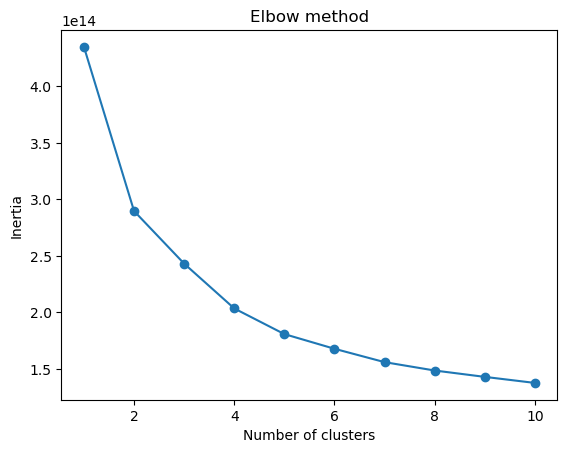

In [8]:
elbow_method_graphic(x,11)

## Creates cluster pivot table

In [9]:
pt = creates_cluster_pivot_table(df)
pt

Cluster,ClusterName,C1,C2,C3,C4,C5,C6
0,c1,0,0,2500,0,0,0
1,c2,0,0,0,0,0,800
2,c3,0,0,0,700,0,0
3,c4,400,0,0,0,0,0
4,c5,0,300,0,0,0,0
5,c6,0,0,0,0,500,0


## Creates dispersion table

In [10]:
tb = creates_dispersion_table(df, dp)

## Scatter plot of pair of features

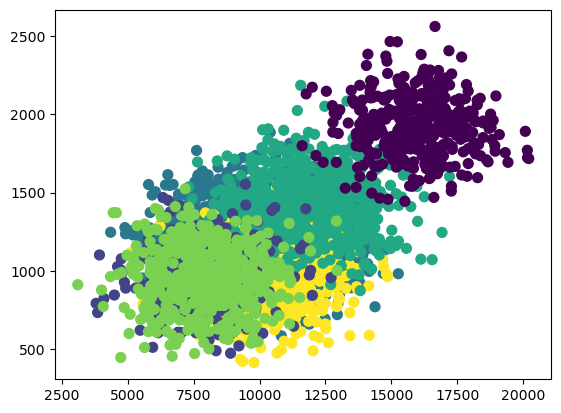

In [11]:
plt.scatter(X[:,  0], X[:, 1], c = df.Cluster, s = 50, cmap = 'viridis')

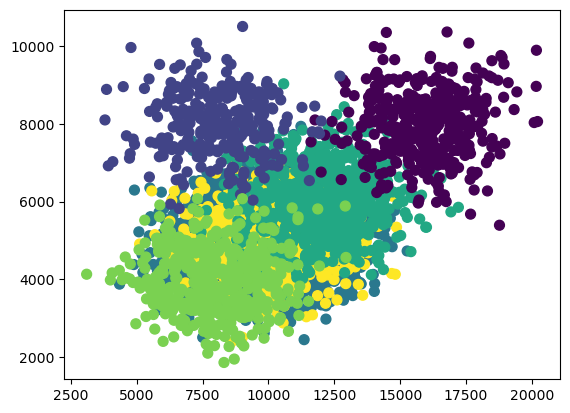

In [12]:
plt.scatter(X[:,  0], X[:, 2], c = df.Cluster, s = 50, cmap = 'viridis')

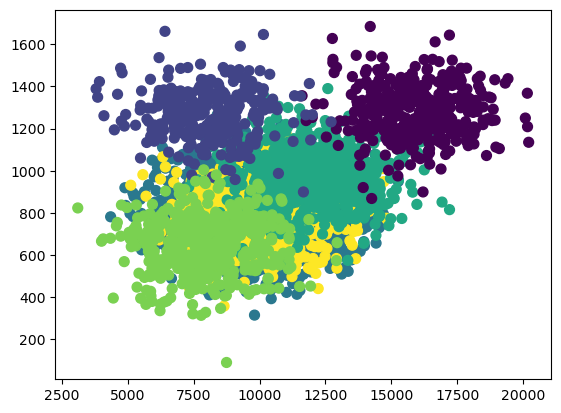

In [13]:
plt.scatter(X[:,  0], X[:, 3], c = df.Cluster, s = 50, cmap = 'viridis')

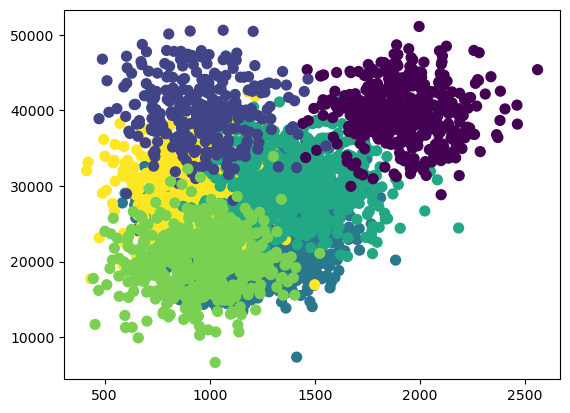

In [14]:
plt.scatter(X[:,  1], X[:, 4], c = df.Cluster, s = 50, cmap = 'viridis')

## Feature pairplot 

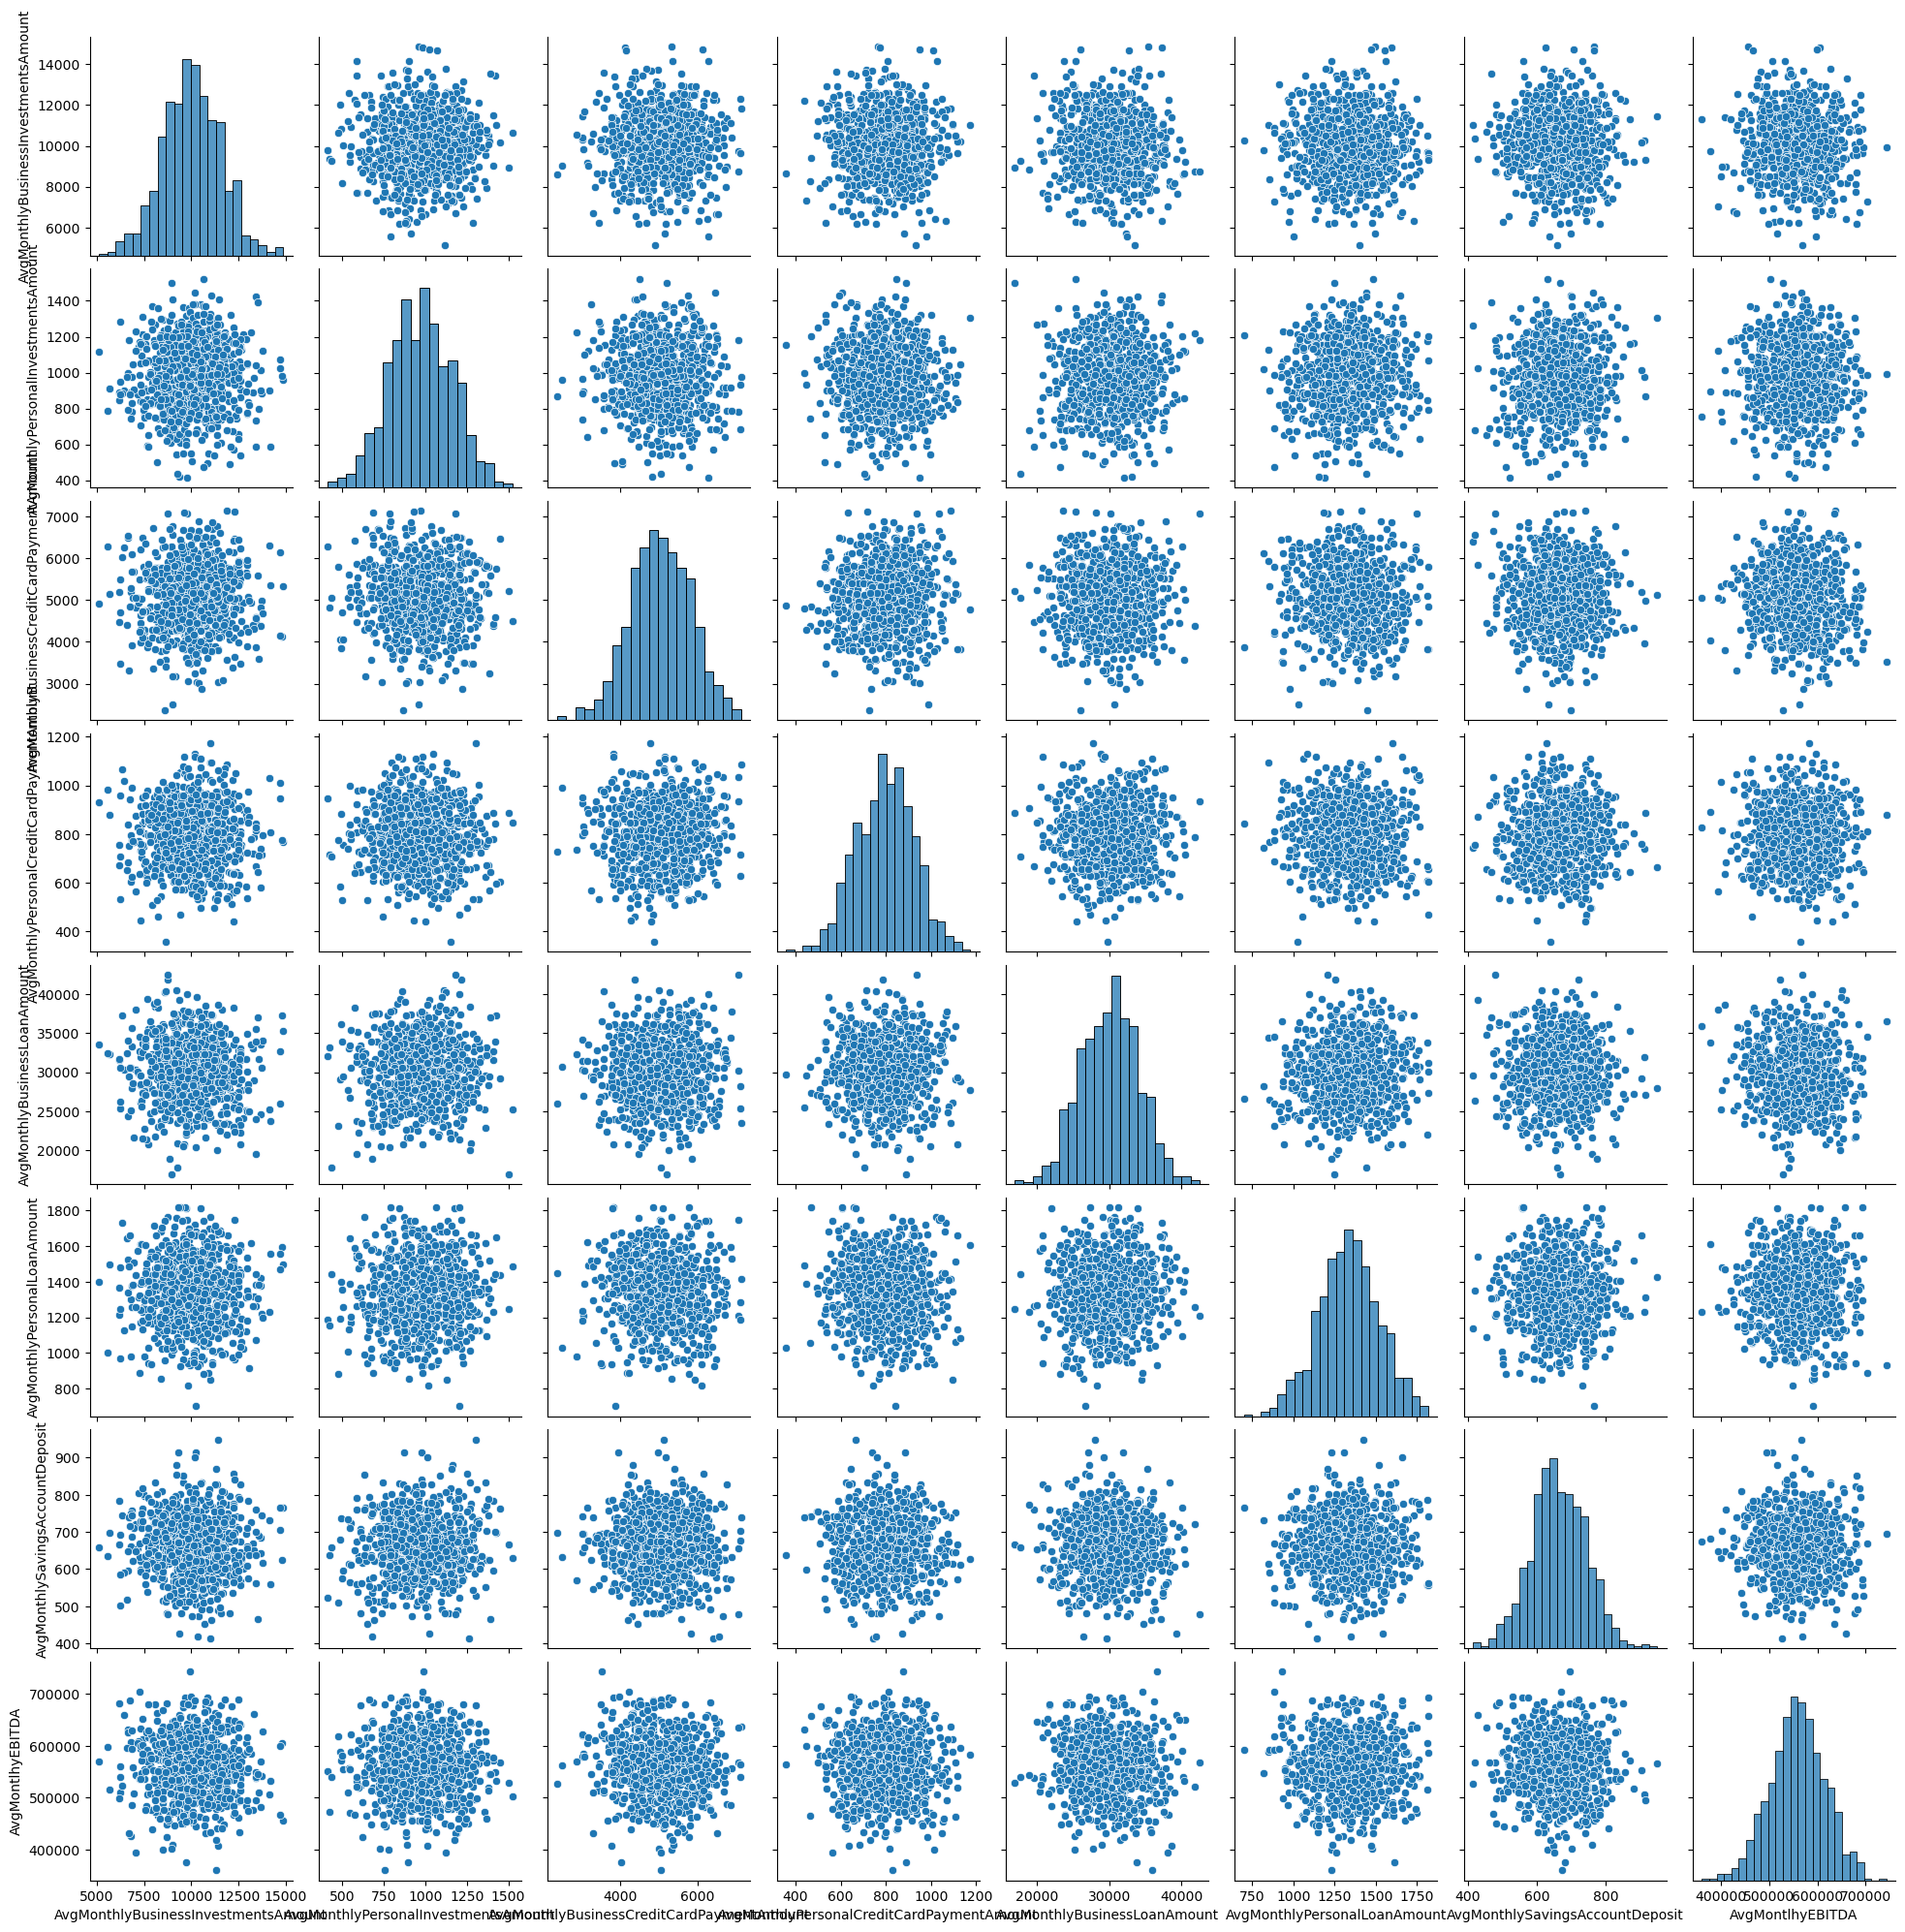

In [15]:
#
x1 = df[['id','ClusterName']].join(x)
#
sns.pairplot(x1[x1['ClusterName'] == 'c2'].iloc[:, 0:10])

## Scatterplot for all the features (using plotly scatter)

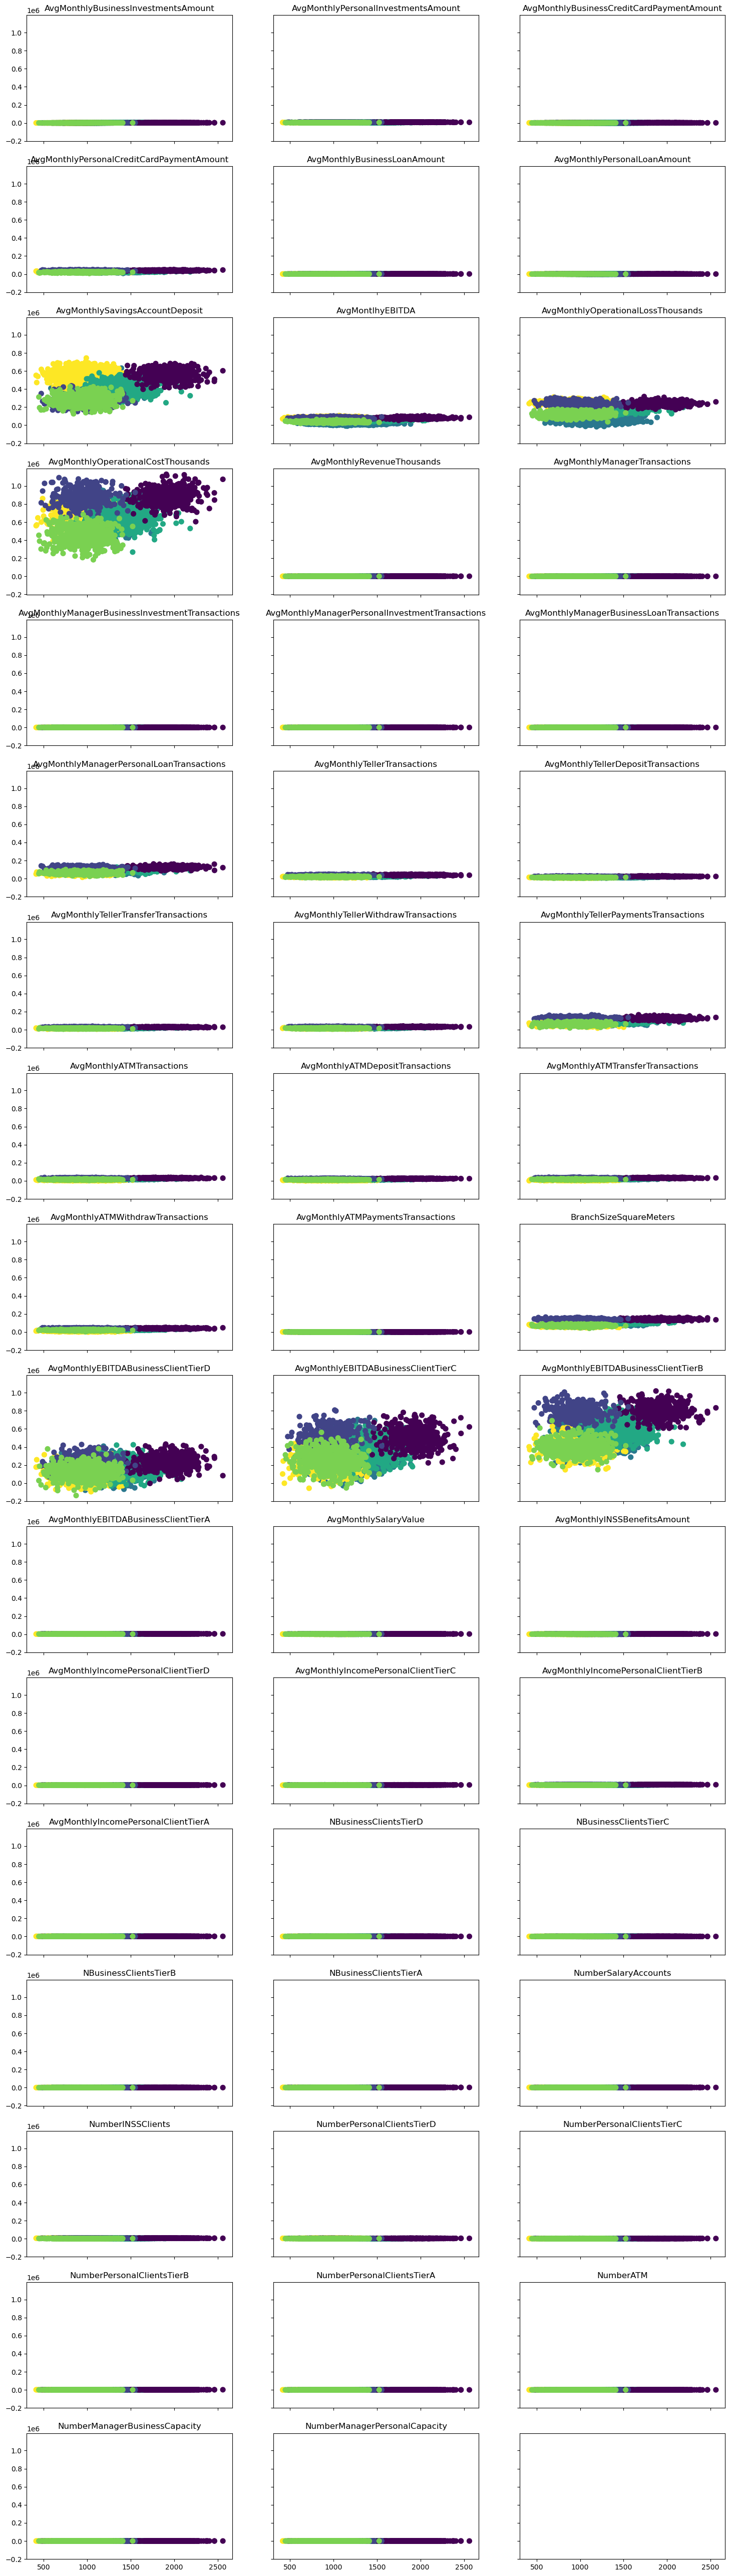

In [16]:
#
fig, axes = plt.subplots(17, 3, figsize = (18, 66), sharex = True, sharey = True)
#
ListColumns = x.columns.tolist()
#
k = 0
for i in range(0,17):
    for j in range(0,3):
            k += 1
            if ((i+1)*(j+1) > X.shape[1]) | k == 51:
                break
            else:
                axes[i,j].scatter(X[:,  1], X[:, k], c = df.Cluster, s = 50, cmap = 'viridis')
                axes[i,j].set_title(ListColumns[k-1])

## Scatter plot of centroids

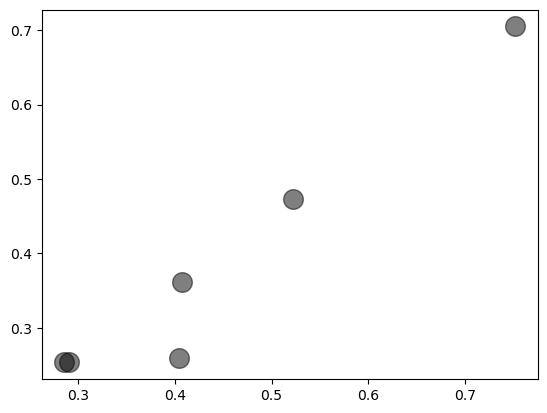

In [17]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

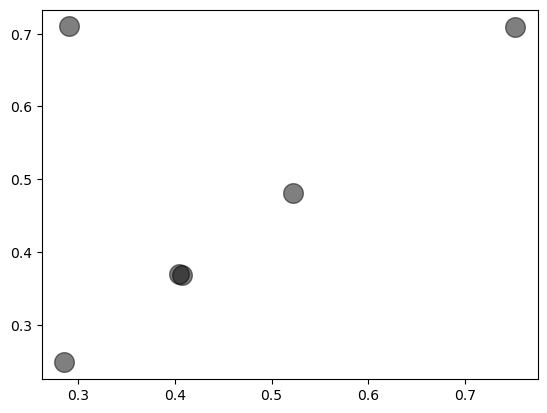

In [18]:
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5)

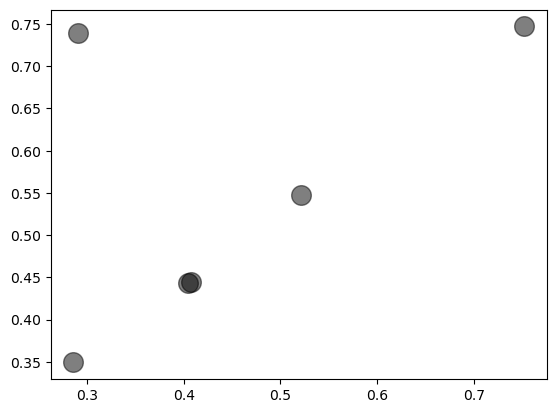

In [19]:
plt.scatter(centers[:, 0], centers[:, 3], c='black', s=200, alpha=0.5)

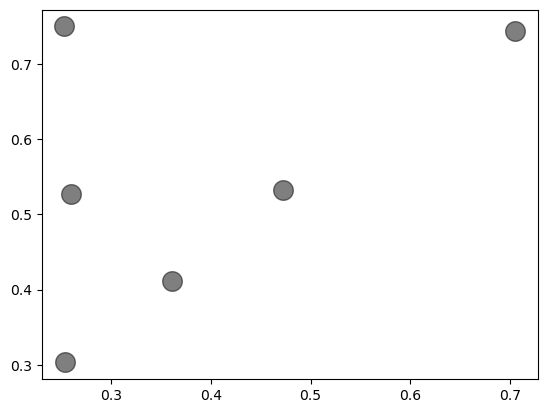

In [20]:
plt.scatter(centers[:, 1], centers[:, 4], c='black', s=200, alpha=0.5)

# Artefacts

In [21]:
#df.to_excel('cluster_analise.xlsx')
df.head(5)

,id,ClusterName,IdBranch,AvgMonthlyBusinessInvestmentsAmount,AvgMonthlyPersonalInvestmentsAmount,AvgMonthlyBusinessCreditCardPaymentAmount,AvgMonthlyPersonalCreditCardPaymentAmount,AvgMonthlyBusinessLoanAmount,AvgMonthlyPersonalLoanAmount,AvgMonthlySavingsAccountDeposit,AvgMontlhyEBITDA,AvgMonthlyOperationalLossThousands,AvgMonthlyOperationalCostThousands,AvgMonthlyRevenueThousands,AvgMonthlyManagerTransactions,AvgMonthlyManagerBusinessInvestmentTransactions,AvgMonthlyManagerPersonalInvestmentTransactions,AvgMonthlyManagerBusinessLoanTransactions,AvgMonthlyManagerPersonalLoanTransactions,AvgMonthlyTellerTransactions,AvgMonthlyTellerDepositTransactions,AvgMonthlyTellerTransferTransactions,AvgMonthlyTellerWithdrawTransactions,AvgMonthlyTellerPaymentsTransactions,AvgMonthlyATMTransactions,AvgMonthlyATMDepositTransactions,AvgMonthlyATMTransferTransactions,AvgMonthlyATMWithdrawTransactions,AvgMonthlyATMPaymentsTransactions,BranchSizeSquareMeters,AvgMonthlyEBITDABusinessClientTierD,AvgMonthlyEBITDABusinessClientTierC,AvgMonthlyEBITDABusinessClientTierB,AvgMonthlyEBITDABusinessClientTierA,AvgMonthlySalaryValue,AvgMonthlyINSSBenefitsAmount,AvgMonthlyIncomePersonalClientTierD,AvgMonthlyIncomePersonalClientTierC,AvgMonthlyIncomePersonalClientTierB,AvgMonthlyIncomePersonalClientTierA,NBusinessClientsTierD,NBusinessClientsTierC,NBusinessClientsTierB,NBusinessClientsTierA,NumberSalaryAccounts,NumberINSSClients,NumberPersonalClientsTierD,NumberPersonalClientsTierC,NumberPersonalClientsTierB,NumberPersonalClientsTierA,NumberATM,NumberManagerBusinessCapacity,NumberManagerPersonalCapacity,NumberTellerCapacity,State,DummyInsideShopping,DummyPrimeZone,Cluster
0,0001,c1,c1_0001,10476,1167,6539,719,23683,1183,574,448528,13003,54616,706184,778,133,74,295,203,53490,23147,16643,21206,18120,99019,20968,14747,16183,24712,472,97967,96447,405975,489345,3354,1086,2232,2892,3126,4538,1046,470,267,79,1232,1070,3266,2844,2266,860,7,2,2,5,SP,0,1,2
1,0002,c1,c1_0002,11422,1194,6108,725,17066,870,738,411536,24814,45102,719314,936,154,105,229,222,73030,26276,13884,20039,24323,92975,23555,15023,19462,22597,601,87937,260258,483701,608115,2866,901,883,2621,3658,4577,861,385,141,84,1091,1257,2876,2940,1732,699,11,2,2,4,PA,0,0,2
2,0003,c1,c1_0003,9989,1093,5970,845,23166,724,668,532963,27880,79508,763271,706,157,67,320,209,83920,26777,18025,18412,22537,59791,20943,17350,13871,19904,431,94617,213450,359060,492132,3331,1678,1571,2121,2572,4651,916,359,228,63,1068,1042,3741,2035,2083,655,4,2,2,5,MT,0,1,2
3,0004,c1,c1_0004,10861,869,4894,882,24866,1086,561,350166,10409,8475,692028,795,181,73,231,234,78984,16903,14897,19002,27536,80627,17999,16694,21121,27082,508,98157,133333,242126,518717,2515,2443,1518,2866,2797,4026,952,502,244,67,1521,1006,3698,2515,1625,840,8,2,2,3,RS,0,1,2
4,0005,c1,c1_0005,8587,963,5489,858,26256,1156,530,372719,32311,71551,597667,819,122,100,319,198,94541,26137,15966,16857,23048,76333,18128,16128,17239,26870,527,86763,172532,252962,500248,2153,811,2388,2078,3144,3968,1093,469,261,74,1498,1289,2935,2642,2729,531,8,2,2,8,GO,0,1,2


In [22]:
x.head(5)

,AvgMonthlyBusinessInvestmentsAmount,AvgMonthlyPersonalInvestmentsAmount,AvgMonthlyBusinessCreditCardPaymentAmount,AvgMonthlyPersonalCreditCardPaymentAmount,AvgMonthlyBusinessLoanAmount,AvgMonthlyPersonalLoanAmount,AvgMonthlySavingsAccountDeposit,AvgMontlhyEBITDA,AvgMonthlyOperationalLossThousands,AvgMonthlyOperationalCostThousands,AvgMonthlyRevenueThousands,AvgMonthlyManagerTransactions,AvgMonthlyManagerBusinessInvestmentTransactions,AvgMonthlyManagerPersonalInvestmentTransactions,AvgMonthlyManagerBusinessLoanTransactions,AvgMonthlyManagerPersonalLoanTransactions,AvgMonthlyTellerTransactions,AvgMonthlyTellerDepositTransactions,AvgMonthlyTellerTransferTransactions,AvgMonthlyTellerWithdrawTransactions,AvgMonthlyTellerPaymentsTransactions,AvgMonthlyATMTransactions,AvgMonthlyATMDepositTransactions,AvgMonthlyATMTransferTransactions,AvgMonthlyATMWithdrawTransactions,AvgMonthlyATMPaymentsTransactions,BranchSizeSquareMeters,AvgMonthlyEBITDABusinessClientTierD,AvgMonthlyEBITDABusinessClientTierC,AvgMonthlyEBITDABusinessClientTierB,AvgMonthlyEBITDABusinessClientTierA,AvgMonthlySalaryValue,AvgMonthlyINSSBenefitsAmount,AvgMonthlyIncomePersonalClientTierD,AvgMonthlyIncomePersonalClientTierC,AvgMonthlyIncomePersonalClientTierB,AvgMonthlyIncomePersonalClientTierA,NBusinessClientsTierD,NBusinessClientsTierC,NBusinessClientsTierB,NBusinessClientsTierA,NumberSalaryAccounts,NumberINSSClients,NumberPersonalClientsTierD,NumberPersonalClientsTierC,NumberPersonalClientsTierB,NumberPersonalClientsTierA,NumberATM,NumberManagerBusinessCapacity,NumberManagerPersonalCapacity,NumberTellerCapacity
0,10476,1167,6539,719,23683,1183,574,448528,13003,54616,706184,778,133,74,295,203,53490,23147,16643,21206,18120,99019,20968,14747,16183,24712,472,97967,96447,405975,489345,3354,1086,2232,2892,3126,4538,1046,470,267,79,1232,1070,3266,2844,2266,860,7,2,2,5
1,11422,1194,6108,725,17066,870,738,411536,24814,45102,719314,936,154,105,229,222,73030,26276,13884,20039,24323,92975,23555,15023,19462,22597,601,87937,260258,483701,608115,2866,901,883,2621,3658,4577,861,385,141,84,1091,1257,2876,2940,1732,699,11,2,2,4
2,9989,1093,5970,845,23166,724,668,532963,27880,79508,763271,706,157,67,320,209,83920,26777,18025,18412,22537,59791,20943,17350,13871,19904,431,94617,213450,359060,492132,3331,1678,1571,2121,2572,4651,916,359,228,63,1068,1042,3741,2035,2083,655,4,2,2,5
3,10861,869,4894,882,24866,1086,561,350166,10409,8475,692028,795,181,73,231,234,78984,16903,14897,19002,27536,80627,17999,16694,21121,27082,508,98157,133333,242126,518717,2515,2443,1518,2866,2797,4026,952,502,244,67,1521,1006,3698,2515,1625,840,8,2,2,3
4,8587,963,5489,858,26256,1156,530,372719,32311,71551,597667,819,122,100,319,198,94541,26137,15966,16857,23048,76333,18128,16128,17239,26870,527,86763,172532,252962,500248,2153,811,2388,2078,3144,3968,1093,469,261,74,1498,1289,2935,2642,2729,531,8,2,2,8


In [23]:
X

array([[10476,  1167,  6539, ...,     2,     2,     5],
       [11422,  1194,  6108, ...,     2,     2,     4],
       [ 9989,  1093,  5970, ...,     2,     2,     5],
       ...,
       [ 8923,   984,  5429, ...,     1,     1,     5],
       [ 8566,   647,  4053, ...,     1,     1,     1],
       [ 9701,  1013,  3542, ...,     1,     1,     1]])

In [24]:
clusters

,Cluster
0,2
1,2
2,2
3,2
4,2
...,...
5195,4
5196,4
5197,4
5198,4


In [25]:
kmeans

KMeans(init='random', n_clusters=6, random_state=42)

In [30]:
tb
tb.to_excel('table_dispersion.xlsx')

In [27]:
tb.groupby(['FeatureGrouping']).mean().reset_index()

,FeatureGrouping,C1Mean,C2Mean,C3Mean,C4Mean,C5Mean,C6Mean,C1Std,C2Std,C3Std,C4Std,C5Std,C6Std,C1Disp,C2Disp,C3Disp,C4Disp,C5Disp,C6Disp
0,BusinessPotential,171126.745750,171891.139000,107419.950240,129043.145429,84538.593600,85928.745875,26661.218589,25893.470534,27162.976960,27094.505018,26403.795438,26654.545144,0.146468,0.142866,0.232796,0.194759,0.291954,0.288268
1,Credit,2517.918125,2516.687500,1585.639200,1894.190000,1262.851500,1612.390312,265.208030,250.260170,249.965601,256.601290,249.046386,248.882824,0.099610,0.096955,0.160550,0.133900,0.199365,0.145993
2,FinancialHealth,438971.606875,369825.394167,293016.629200,328919.929286,221176.588000,385464.837813,43576.911159,44869.856432,43757.375848,44463.483406,44659.448065,45313.813620,0.098470,0.126953,0.244140,0.134649,0.200307,0.110502
3,Investment,198.505000,99.561667,124.890200,149.234286,99.800000,150.096250,19.696279,19.398116,20.155628,19.509430,20.627550,20.096931,0.100298,0.196178,0.161165,0.131367,0.206450,0.134220
4,Size,1422.796833,1380.777333,890.528373,1011.004000,610.091200,1324.283750,166.459916,164.838297,169.180067,167.169719,162.892335,168.009728,0.110430,0.119789,0.180022,0.165185,0.295263,0.127058
5,TransactionValue,12056.016500,10341.886000,7578.262720,9154.858571,6081.737600,8613.388750,1150.960224,1267.606079,1224.910780,1161.576001,1183.632636,1210.049430,0.098160,0.140974,0.160580,0.133453,0.199203,0.148829
6,TransactionVolume,45937.742727,45683.052424,28623.015382,34415.996234,22846.360364,20520.275909,4523.888675,4648.138350,4627.411266,4559.170064,4656.460300,4558.451304,0.097967,0.101221,0.160393,0.131833,0.202993,0.250105


# References

**Statistical Distributions**
* https://docs.scipy.org/doc/scipy/reference/stats.html
* https://towardsdatascience.com/deep-diving-statistical-distributions-with-python-for-data-scientists-a0a4badc8d1a

**Bank Branching and Applications of KMeans**
* https://sci-hub.se/https://www.sciencedirect.com/science/article/abs/pii/S0957417415008271?via%3Dihub
* https://www.sciencedirect.com/science/article/abs/pii/S0957417415008271?via%3Dihub
* https://www.textroad.com/pdf/JAEBS/J.%20Appl.%20Environ.%20Biol.%20Sci.,%205(5)458-464,%202015.pdf
* https://onlinelibrary.wiley.com/doi/10.1002/isaf.1471
* https://sci-hub.se/https://onlinelibrary.wiley.com/doi/10.1002/isaf.1471

**KMeans**
* https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* https://www.w3schools.com/python/python_ml_k-means.asp
* https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

**Visualizações**
* https://seaborn.pydata.org/tutorial/distributions.html